# Application empirique double selection: effet du niveau de diplôme sur le salaire (données enquête emploi)

Jérémy L'Hour

29/05/2020

In [1]:
rm(list=ls())

### CHARGEMENT DES PACKAGES
library('haven')
library('glmnet')
library('grplasso') # pour group-lasso
library("ggplot2")
library('fastDummies') # pour créer des dummies à partir de catégories

### Algorithme de calcul du group lasso, plus rapide que le package ici
source('functions/group_lasso.R')

Loading required package: Matrix

Loaded glmnet 3.0-2




In [2]:
#######################
#######################
### DATA MANAGEMENT ###
#######################
#######################

#data = read_sas("indiv171.sas7bdat")
data = read_sas("/Users/jeremylhour/Documents/data/indiv171.sas7bdat")
data = as.data.frame(data)

# Outcome "Y", log du salaire mensuel net
data[,"SALRED"] = as.numeric(data[,"SALRED"]) # salaire mensuel net
data[,"LOG_SAL"] = log(data[,"SALRED"]) # log salaire

# Variable d'intérêt, "X_1", en facteurs à plusieurs niveaux
data[,"DIP"] = ifelse(data[,"DIP"]=="",NA,data[,"DIP"])
data[,"DIP"] = as.factor(data[,"DIP"]) # niveau de diplome le plus eleve


data[,"EXTRIDF"] = as.numeric(data[,"EXTRIDF"]) # poids de sondages

# Autres variables "X_2"
# 1. Continues
data[,"AG"] = as.numeric(data[,"AG"]) # Age
data[,"AG_2"] = data[,"AG"]^2 # Age au carré
data[,"ANCENTR"] = as.numeric(data[,"ANCENTR"]) # Ancienneté dans l'entreprise
data[,"HHC"] = as.numeric(data[,"HHC"]) # Nombre d'heures travaillées en moyenne
data[,"NBENFIND"] = as.numeric(data[,"NBENFIND"]) # Nombre d'enfants de l'individu

names_continuous = c("AG", "AG_2", "ANCENTR","HHC","NBENFIND")

# 2. Variables categorielles
data[,"SEXE"] = as.factor(data[,"SEXE"]) # Sexe
data[,"APPDIP"] = as.factor(data[,"APPDIP"]) # diplôme obtenu en apprentissage
data[,"SANTGEN"] = as.factor(data[,"SANTGEN"]) # niveau de santé perçu
data[,"ADMHAND"] = as.factor(data[,"ADMHAND"]) # reconnaissance d'un handicap
data[,"CATAU2010"] = as.factor(data[,"CATAU2010"]) # categorie de la commune du logement de residence
data[,"CHPUB"] = as.factor(data[,"CHPUB"]) # nature de l'employeur dans profession principale
data[,"CHRON"] = as.factor(data[,"CHRON"]) # maladie chronique
data[,"COMSAL"] = as.factor(data[,"COMSAL"]) # mode d'entrée dans l'emploi actuel
data[,"COURED"] = as.factor(data[,"COURED"]) # en couple
data[,"CSPM"] = as.factor(data[,"CSPM"]) # CSP Mere
data[,"CSPP"] = as.factor(data[,"CSPP"]) # CSP Pere
data[,"FORDAT"] = as.factor(data[,"FORDAT"]) # annee de fin d'études initiales
data[,"DESC"] = as.factor(data[,"DESC"]) # descendance d'immigrés
data[,"IMMI"] = as.factor(data[,"IMMI"]) # immigre
data[,"DUHAB"] = as.factor(data[,"DUHAB"]) # type d'horaires de travail
data[,"ENFRED"] = as.factor(data[,"ENFRED"]) # au moins un enfant dans le menage
data[,"SPE"] = as.factor(data[,"SPE"]) # champs des études suivies (e.g. science, lettre education)
data[,"MAISOC"] = as.factor(data[,"MAISOC"]) # teletravail
data[,"MATRI"] = as.factor(data[,"MATRI"]) # statut matrimonial
data[,"NAT14"] = as.factor(data[,"NAT14"]) # nationalité
data[,"NBAGEENFA"] = as.factor(data[,"NBAGEENFA"]) # nombre et age des enfants
data[,"NBENFA1"] = as.factor(data[,"NBENFA1"]) # nombre d'enfants de moins de 1 an
data[,"NBENFA10"] = as.factor(data[,"NBENFA10"]) # nombre d'enfants de moins de 10 ans
data[,"NBENFA15"] = as.factor(data[,"NBENFA15"]) # nombre d'enfants de moins de 15 ans
data[,"NBENFA18"] = as.factor(data[,"NBENFA18"]) # nombre d'enfants de moins de 18 ans
data[,"QP"] = as.factor(data[,"QP"]) # appartient à un quartier prioritaire
data[,"REG"] = as.factor(data[,"REG"]) # region du logement de résidence
data[,"SO"] = as.factor(data[,"SO"]) # statut d'occupation du logement
data[,"SOIRC"] = as.factor(data[,"SOIRC"]) # travaille le soir
data[,"TYPMEN21"] = as.factor(data[,"TYPMEN21"]) # type de ménage

names_categorical = c("SEXE","APPDIP","SANTGEN","ADMHAND","CATAU2010", "CHPUB","CHRON",
                      "COMSAL","COURED","CSPM","CSPP","FORDAT","DESC","IMMI","DUHAB","ENFRED","SPE",
                      "MAISOC","MATRI","NAT14","NBAGEENFA","NBENFA1","NBENFA10","NBENFA15","NBENFA18","QP","REG","SO","SOIRC","TYPMEN21")

# 3. Autres
data[,"AM2NB"] = as.factor(data[,"AM2NB"]) # Nombre d'activité professionnelles  // Trop de valeurs manquantes
data[,"ACESSE"] = as.factor(data[,"ACESSE"]) # Circonstance fin de l'emploi anterieur // A mettre?


### Mise en place des bonnes matrices
outcome = "LOG_SAL"
X_1_names = "DIP"
X_2_names = c(names_continuous,names_categorical)

data_use = data[complete.cases(data[,c(outcome,X_1_names,X_2_names)]),]

Y = data_use[,outcome]
X_1 = model.matrix(~. - 1, data = data.frame("EDUC"=as.factor(data_use[,X_1_names])), contrasts.arg = "EDUC")
#X_1 = makeX(data.frame("EDUC"=as.factor(data_use[,X_1_names])))
X_1 = X_1[,1:(ncol(X_1)-1)] # On enlève la modalité "sans diplôme" pour éviter les problèmes de colinéarité.


# se poser la question de la gestion des NA pour les autres variables (X_2)
#pre_X_2 = data_use[,X_2_names]
#pre_X_2[pre_X_2 == ""] = NA
#md.pattern(pre_X_2)

one_hot_category = dummy_cols(data_use[,names_categorical], remove_most_frequent_dummy=TRUE, remove_selected_columns=TRUE)
X_2 = as.matrix(cbind(data_use[, names_continuous], one_hot_category))

remove(data)
remove(data_use)
remove(one_hot_category)

Warning message in model.matrix.default(~. - 1, data = data.frame(EDUC = as.factor(data_use[, :
“non-list contrasts argument ignored”


In [3]:
### Régression simple, sans variables de contrôle
coef_names = paste("X_1",colnames(X_1),sep="")

reg_simple = lm(Y ~ X_1)
summary(reg_simple)
tau_simple = reg_simple$coefficients[coef_names]


Call:
lm(formula = Y ~ X_1)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1237 -0.2230  0.0493  0.3114  3.4800 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.02750    0.01425 493.201  < 2e-16 ***
X_1EDUC10    0.78228    0.02187  35.774  < 2e-16 ***
X_1EDUC12    0.89849    0.02480  36.231  < 2e-16 ***
X_1EDUC21    0.50870    0.02359  21.560  < 2e-16 ***
X_1EDUC22    0.70710    0.02939  24.056  < 2e-16 ***
X_1EDUC30    0.42616    0.04620   9.224  < 2e-16 ***
X_1EDUC31    0.49588    0.02007  24.708  < 2e-16 ***
X_1EDUC32    0.43897    0.05923   7.412 1.32e-13 ***
X_1EDUC33    0.56342    0.03104  18.149  < 2e-16 ***
X_1EDUC41    0.21756    0.02523   8.623  < 2e-16 ***
X_1EDUC42    0.35220    0.02450  14.377  < 2e-16 ***
X_1EDUC43    0.23907    0.02306  10.368  < 2e-16 ***
X_1EDUC44    0.31316    0.03234   9.685  < 2e-16 ***
X_1EDUC50    0.25494    0.01701  14.991  < 2e-16 ***
X_1EDUC60    0.10880    0.02516   4.325 1.54e-05 ***
X_1EDUC70   -0

In [4]:
### Régression complète, avec toutes les variables de contrôle
reg_full= lm(Y ~ X_1 + X_2)
tau_full = reg_full$coefficients[coef_names]
sigma_full = summary(reg_full)$coefficients[coef_names, 2]

In [5]:
############################################
############################################
### ETAPE 1: Selection par rapport à "Y" ###
############################################
############################################

# Il s'agit d'une régression Lasso classique

n = nrow(X_2); p = ncol(X_2)
gamma_pen = .1/log(max(p,n))
lambda = 1.1*qnorm(1-.5*gamma_pen/p)/sqrt(n) # niveau (theorique) de penalisation Lasso

outcome_selec = glmnet(X_2,Y, family="gaussian",alpha=1,lambda=lambda)
predict(outcome_selec,type="coef")

set_Y = predict(outcome_selec,type="nonzero") # ensemble des coefficients non nuls à cette étape

naive_reg = lm(Y ~ X_1 + X_2[,unlist(set_Y)]) # Naive regression
tau_naive = naive_reg$coefficients[coef_names]

369 x 1 sparse Matrix of class "dgCMatrix"
                         s0
(Intercept)    6.4729122249
AG             0.0007819690
AG_2           .           
ANCENTR        0.0006711545
HHC            0.0224350192
NBENFIND       .           
SEXE_1         0.0341273891
APPDIP_       -0.0913921122
APPDIP_1       .           
SANTGEN_       .           
SANTGEN_1      .           
SANTGEN_3      .           
SANTGEN_4      .           
SANTGEN_5      .           
SANTGEN_8      .           
SANTGEN_9      .           
ADMHAND_       .           
ADMHAND_1      .           
ADMHAND_2      .           
ADMHAND_8      .           
ADMHAND_9      .           
CATAU2010_112  .           
CATAU2010_120  .           
CATAU2010_211  .           
CATAU2010_212  .           
CATAU2010_221  .           
CATAU2010_222  .           
CATAU2010_300  .           
CATAU2010_400  .           
CHPUB_         .           
CHPUB_2        .           
CHPUB_3        .           
CHPUB_4        .           
CHPUB

In [6]:
##################################################################
##################################################################
### ETAPE 2: Selection par rapport à "X_1" avec le group Lasso ###
##################################################################
##################################################################

# Cette seconde étape est plus compliquée: la variable X_1 possèdre plusieurs modalités,
# Il faut donc binariser (les convertir en one-hot) et faire autant de régressions qu'il y a de modalités
# On propose une approche Group-Lasso dans la mesure où l'on suppose que le schéma de sparsité est le même pour toutes ces régressions.
# Cela nécessite de faire des régression empiler et de vectoriser la variable dépendante si on utilise le package grplasso, ce qui est très long.
# Depuis group-lasso implémenté manuellement.
# Pour le Group Lasso il y a donc p groupes de variables

# ajustement de la pénalisation
gamma_pen = .1/log(ncol(X_1)*max(p,n))
lambda = 1.1*qnorm(1-.5*gamma_pen/(ncol(X_1)*p))/sqrt(ncol(X_1)*n) # niveau (theorique) de penalisation Lasso

### VERSION A: avec le package grplasso -- ATTENTION TRES GOURMAND!
# X_1_vec = matrix(c(X_1), ncol=1)
# X_2_vec =  kronecker(diag(ncol(X_1)), X_2) # ATTENTION: Prend 8.5 Go de place...
# group_index = rep(1:p,ncol(X_1))
# 
# immunization_selec = grplasso(X_2_vec, X_1_vec, group_index, lambda=n*lambda, model=LinReg()) # ici la fonction objectif est differente, il faut multiplier la penalité par n
# Gamma_hat = matrix(immunization_selec$coefficients, ncol=ncol(X_1))
# row.names(Gamma_hat) = colnames(X_2)

La version ci-dessus utilise le package grplasso. Cela contraint à vectoriser les matrices et prend énormément de place inutile (jusqu'à 8.5 Go ici). L'utiliser n'est pas recommandé. On a recodé un algorithme FISTA pour calculer la solution Group-Lasso.

In [7]:
### VERSION B: avec implémentation manuelle -- bien plus rapide
immunization_selec_man = group_lasso(X_2,X_1,lambda=lambda,trace=TRUE)
Gamma_hat = immunization_selec_man$beta[-p-1,]

set_X1 = c(which(apply(Gamma_hat>0,1,sum)>0))

[1] "Objective Func. Value at iteration 100 : 0.0534597574869055"
[1] "Objective Func. Value at iteration 200 : 0.0529186416181083"
[1] "Objective Func. Value at iteration 300 : 0.0525189764687232"
[1] "Objective Func. Value at iteration 400 : 0.0524049321898561"
Time difference of 2.793946 mins


In [8]:
#############################
#############################
### ETAPE 3: Etape finale ###
#############################
#############################

S_hat = sort(unique(unlist(union(set_Y,set_X1))))
dbs_reg = lm(Y ~ X_1 + X_2[,S_hat])
tau_hat = dbs_reg$coefficients[coef_names]

### Calcul de l'écart-type
Gamma_hat = solve(t(X_2[,S_hat])%*%X_2[,S_hat]) %*% (t(X_2[,S_hat]) %*% X_1) # Regression post-lasso de chaque modalités de X_1
treat_residuals = X_1 - X_2[,S_hat] %*% Gamma_hat

M_matrix = sweep(t(treat_residuals),MARGIN=2,dbs_reg$residuals,`*`) %*% t(sweep(t(treat_residuals),MARGIN=2,dbs_reg$residuals,`*`)) /(n - ncol(X_1) - length(S_hat) - 1)
C_matrix = t(treat_residuals)%*%treat_residuals / n
sigma = sqrt(solve(C_matrix) %*% M_matrix %*% solve(C_matrix)) / sqrt(n) 

In [12]:
dip = data.frame("ID" = c("10","12","22","21","30","31","32","33","41","42","43","44","50","60","70"),
            "Diplome" = c("Master (recherche ou professionnel), DEA, DESS, Doctorat",
              "Ecoles niveau licence et au-delà",
              "Maîtrise (M1)",
              "Licence (L3)",
              "DEUG",
              "DUT, BTS",
              "Autre diplôme (niveau bac+2)",
              "Paramédical et social (niveau bac+2)",
              "Baccalauréat général",
              "Bac technologique",
              "Bac professionnel",
              "Brevet de technicien, brevet professionnel",
              "CAP, BEP",
              "Brevet des collèges",
              "Certificat d'études primaires"),
            "lower_bound" = tau_hat + qnorm(0.025)*diag(sigma),
            "Coefficient" = tau_hat,
            "upper_bound" = tau_hat + qnorm(0.975) *diag(sigma),
            "Moyenne" = tau_simple,
            "Naive" = tau_naive,
            "Full" = tau_full,
            "Full_lb" = tau_full + qnorm(0.025)*sigma_full,
            "Full_ub" = tau_full + qnorm(0.975) *sigma_full)

print(dip[,c("Diplome","Coefficient","lower_bound","upper_bound")]) # On imprime l'estimateur de double-sélection ainsi que l'intervalle de confiance à 95% pour chaque modalité du diplôme.

                                                           Diplome Coefficient
X_1EDUC10 Master (recherche ou professionnel), DEA, DESS, Doctorat  0.56992994
X_1EDUC12                         Ecoles niveau licence et au-delà  0.60491012
X_1EDUC21                                            Maîtrise (M1)  0.37174704
X_1EDUC22                                             Licence (L3)  0.44162197
X_1EDUC30                                                     DEUG  0.21760354
X_1EDUC31                                                 DUT, BTS  0.32251901
X_1EDUC32                             Autre diplôme (niveau bac+2)  0.27256217
X_1EDUC33                     Paramédical et social (niveau bac+2)  0.40857818
X_1EDUC41                                     Baccalauréat général  0.15263666
X_1EDUC42                                        Bac technologique  0.20284558
X_1EDUC43                                        Bac professionnel  0.22294726
X_1EDUC44               Brevet de technicien, brevet

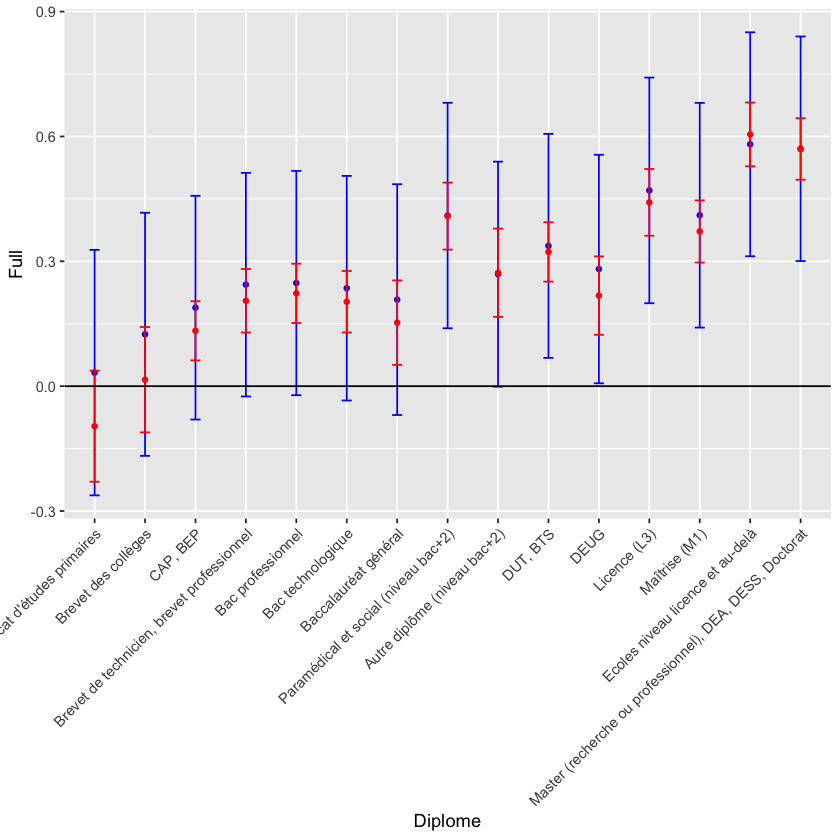

In [13]:
#################
#################
### GRAPHIQUE ###
#################
#################


dodge = position_dodge(.7)

ggplot(data=dip, aes(x = Diplome, y = Full, group=ID)) +
  geom_point(color="blue",fill="blue",shape=16) +
  geom_errorbar(aes(ymin  = Full_lb, ymax  = Full_ub, width = 0.2), color="blue") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_x_discrete(limits=rev(dip$Diplome)) +
  geom_point(aes(x = Diplome, y = Coefficient, group=ID), color="red",fill="red",shape=16, position = dodge) +
  geom_errorbar(aes(ymin  = lower_bound, ymax  = upper_bound, group=ID, width = 0.2), color = "red", position = dodge) +
  geom_abline(slope=0,intercept=0)




Le graphique ci-dessus donne, pour chaque modalité de la variable "diplôme", l'estimateur et l'intervalle de confiance à 95% selon deux méthodes: une méthode brutale où toutes les variables de contrôle sont ajoutées au modèle et la méthode de double-sélection. On constate que la méthode de la double-sélection permet un gain important en terme d'écart-type, rendant un certain nombre de modalités significatives par rapport au fait de ne pas avoir de diplôme.